Jerusalem Light Rail Isochrone Walking Map

Omer Galer

Inspired by [Elad Alfassa](https://github.com/elad661/metroTLV_walkshed) and based on [Geoff Boeing](https://github.com/gboeing/osmnx)

In [58]:
# install the OSMnx package to manipulate OpenStreetMap data using conda
# !conda create -n ox -c conda-forge --strict-channel-priority osmnx

In [ ]:
!pip install geopandas osmnx shapely folium matplotlib
import geopandas as gpd
import pandas as pd
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm
from shapely.geometry import Point, Polygon, MultiPolygon, LineString
from shapely.geometry import mapping
from shapely import MultiLineString
from shapely.ops import unary_union
import shapely.geometry
from descartes import PolygonPatch
import json 

Load station locations using geojson, from geo.mot.gov.il

Read the stations and lines data into geo-data frames

In [14]:
# Load the filtered GeoJSON files
stations_jerusalem = gpd.read_file('./data/jlem_lrt_stations.geojson')
lines_jerusalem = gpd.read_file('./data/jlem_lrt_lines.geojson')


Download and prep the street network graph

In [62]:
# Define the location
place_name = "Jerusalem, Israel"
# Retrieve the street network for Jerusalem
G = ox.graph_from_place(place_name, network_type='walk')



In [63]:
# project the graph to UTM
gdf_nodes = ox.graph_to_gdfs(G, edges=False)
x, y = gdf_nodes["geometry"].unary_union.centroid.xy
center_node = ox.distance.nearest_nodes(G, x[0], y[0])
G = ox.project_graph(G)

C:\Users\omerg\AppData\Local\Temp\ipykernel_3292\2259039439.py:3: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  x, y = gdf_nodes["geometry"].unary_union.centroid.xy


In [ ]:
graph_gdf = ox.graph_to_gdfs(G, nodes=True, edges=False)

# make sure the stns and lines are in the same coord system
stations_jerusalem = stations_jerusalem.to_crs(graph_gdf.crs)
lines_jerusalem = lines_jerusalem.to_crs(graph_gdf.crs)

In [64]:
# add an edge attribute for time in minutes required to traverse each edge
meters_per_minute = 4.5 * 1000 / 60  # km per hour to m per minute
for _, _, _, data in G.edges(data=True, keys=True):
    data["time"] = data["length"] / meters_per_minute
trip_times = [5, 10, 15, 20] # we'll use four isochrone bands  

Walking distances from the centre node

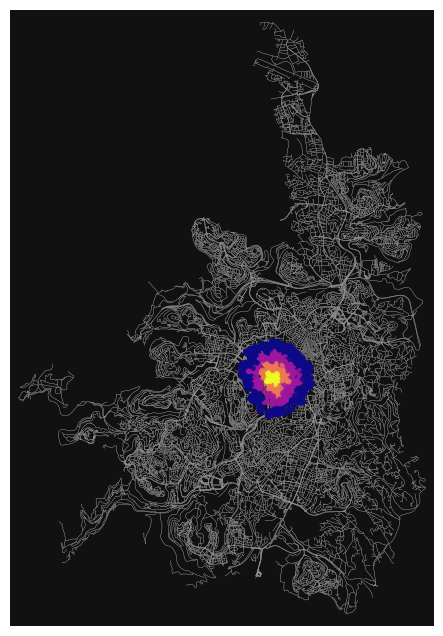

In [65]:
# get one color for each isochrone
iso_colors = ox.plot.get_colors(n=len(trip_times), cmap="plasma", start=0, return_hex=True)
iso_colors.reverse()
# color the nodes according to isochrone then plot the street network
node_colors = {}
for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
    subG = nx.ego_graph(G, center_node, radius=trip_time, distance="time")
    for node in subG.nodes():
        node_colors[node] = color
nc = [node_colors[node] if node in node_colors else "none" for node in G.nodes()]
ns = [15 if node in node_colors else 0 for node in G.nodes()]
fig, ax = ox.plot_graph(
    G,
    node_color=nc,
    node_size=ns,
    node_alpha=0.8,
    edge_linewidth=0.2,
    edge_color="#999999",
)

In [221]:
# Collect nodes closest to each LRT station #TODO: Refactor needed??
lrt_station_nodes = []
for feature in tqdm(stations_jerusalem.iterrows(), 'Loading station nodes'):
    coords = feature[1]['geometry'].coords
    node = ox.distance.nearest_nodes(G, float(coords.xy[0][0]), float(coords.xy[1][0]))
    lrt_station_nodes.append({"node": node})
print(f'Successfully loaded {len(lrt_station_nodes)} LRT station locations')

loading stations: 126it [00:18,  6.90it/s]

loaded 126 LRT station locations


Plot time-distance isochrones

In [126]:
#generate isochrones for walking times from a given node 
    
def isochronate(G, center_node, edge_buff=25, node_buff=50, infill=False):
    isochrone_polys = {}
    for trip_time in sorted(trip_times, reverse=True):
        #for each walking time (5, 10, 15, 20 mins), make a subgraph centred at the 
        #station currently being processed, with a radius equal to the trip time
        subG = nx.ego_graph(G, center_node, radius=trip_time, distance="time")

        node_points = [Point((data["x"], data["y"])) for node, data in subG.nodes(data=True)]
        nodes_gdf = gpd.GeoDataFrame({"id": list(subG.nodes)}, geometry=node_points)
        nodes_gdf = nodes_gdf.set_index("id")

        edge_lines = []
        #create line strings from the subgraph
        for n_fr, n_to in subG.edges():
            f = nodes_gdf.loc[n_fr].geometry
            t = nodes_gdf.loc[n_to].geometry
            edge_lookup = G.get_edge_data(n_fr, n_to)[0].get("geometry", LineString([f, t]))
            edge_lines.append(edge_lookup)

        n = nodes_gdf.buffer(node_buff).geometry
        e = gpd.GeoSeries(edge_lines).buffer(edge_buff).geometry
        all_gs = list(n) + list(e)
        #create the isochrone from the union of the subgraph 
        new_iso = gpd.GeoSeries(all_gs).unary_union
        #fill in empty spaces
        if infill and hasattr(new_iso, 'exterior'):
            new_iso = Polygon(new_iso.exterior)
        isochrone_polys[trip_time] = new_iso
    return isochrone_polys #return the isochrone polygons

In [73]:
def get_geojson_geometry(polygon):
    """Get geojson-compatible geometry."""
    return mapping(polygon)

In [74]:
# Generate isochrone polygons, grouped by time
lrt_time_polys = {key: [] for key in trip_times}

for station in tqdm(lrt_station_nodes, 'making polys'):
    isochrone_polys = isochronate(G, station['node'], edge_buff=25, node_buff=0, infill=True)
    for time, polygon in isochrone_polys.items():
        lrt_time_polys[time].append({'poly': polygon})

making polys:   0%|          | 0/126 [00:00<?, ?it/s]C:\Users\omerg\AppData\Local\Temp\ipykernel_3292\3525090258.py:23: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  new_iso = gpd.GeoSeries(all_gs).unary_union
C:\Users\omerg\AppData\Local\Temp\ipykernel_3292\3525090258.py:23: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  new_iso = gpd.GeoSeries(all_gs).unary_union
C:\Users\omerg\AppData\Local\Temp\ipykernel_3292\3525090258.py:23: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  new_iso = gpd.GeoSeries(all_gs).unary_union
C:\Users\omerg\AppData\Local\Temp\ipykernel_3292\3525090258.py:23: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  new_iso = gpd.GeoSeries(all_gs).unary_union
making polys:   1%|          | 1/126 [00:03<06:43,  3.23s/it]C:\Users\omerg\AppData\Local\T

In [76]:
#map the hebrew to english line names
colours = {"אדום": "red", "ירוק": "green", "ירוק בהיר": "limegreen", "כחול": "blue", "כחול בהיר": "deepskyblue", "סגול": "purple", "כתום": "orange", "צהוב" :"yellow"}

Plot the isochrones on a street map 

Drawing for 20
Drawing for 15
Drawing for 10
Drawing for 5


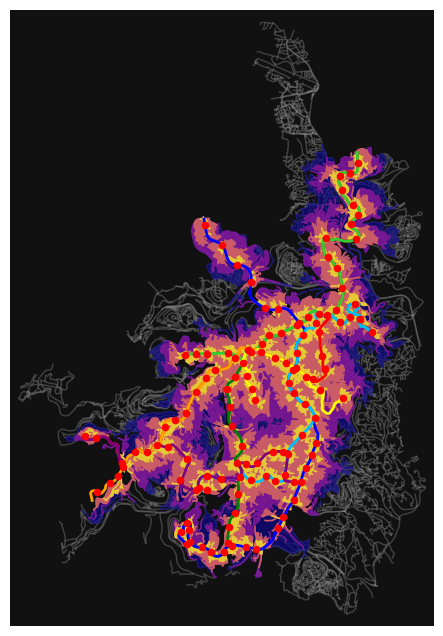

In [77]:
z_index = { key: value for key, value in zip(trip_times, sorted(trip_times, reverse=True)) }
fig, ax = ox.plot_graph(
    G, show=False, close=False, edge_color="#999999", edge_alpha=0.2, node_size=0
)
geojson_features = []
#merge the isochrones so they can be plotted 
for [time, polys], fc in zip(reversed(lrt_time_polys.items()), iso_colors):
    print(f'Drawing for {time}')
    union = shapely.ops.unary_union([poly['poly'] for poly in polys])
    if isinstance(union, Polygon):
        union = [union]  # Make it iterable if it's a single Polygon
    elif isinstance(union, MultiPolygon):
        union = list(union.geoms)  
    else:
        union = []

    for polygon in union:
        geojson_features.append({
            "type": "Feature", 
            "properties": { "time": time, "color": fc }, 
            "geometry": get_geojson_geometry(polygon)
        })
        patch = PolygonPatch(polygon, fc=fc, ec="none", alpha=0.7, zorder=z_index[time])
        ax.add_patch(patch)

geojson = {"type": "FeatureCollection", "features": geojson_features}

#save the final merged isochrones for all stations
with open('./jlem_lrt_dist_iso.geojson', 'w') as f:
    json.dump(geojson, f)

#plot the lines 
for _, row in lines_jerusalem.iterrows():
    colour = colours.get(row['Name'], 'black')  # Default to black if no colour found
    if isinstance(row.geometry, LineString):
        gpd.GeoSeries([row.geometry]).plot(ax=ax, linewidth=2, zorder=21, color=colour)
    elif isinstance(row.geometry, MultiLineString):
        for line in row.geometry.geoms:
            gpd.GeoSeries([line]).plot(ax=ax, linewidth=2, zorder=21, color=colour)
#plot the stations
stations_jerusalem.plot(ax=ax, color='red', markersize=20, zorder=22)
plt.show()


In [79]:
# Reproject isochrones
geojson_stns_proj = geojson_features
# Create a GeoDataFrame from the geojson_features
gdf = gpd.GeoDataFrame.from_features(geojson_stns_proj, crs="EPSG:32636")

# Reproject the GeoDataFrame to EPSG:4326
gdf = gdf.to_crs(epsg=4326)

# Convert the reprojected GeoDataFrame back to a GeoJSON-like structure
reprojected_geojson_features = json.loads(gdf.to_json())

# Save the reprojected GeoJSON to disk
with open('./jlem_lrt_dist_iso_reprojected.geojson', 'w') as f:
    json.dump(reprojected_geojson_features, f)

In [84]:
#add a colour property to each line
lines_jerusalem['colour'] = lines_jerusalem['Name'].map(colours)

def get_line_geojson(line_df):
    features = []
    for _, row in line_df.iterrows():
        colour = row['colour']  # Retrieve color from the dataframe
        geom = shapely.geometry.mapping(row.geometry)
        features.append({
            "type": "Feature",
            "properties": {"color": colour},
            "geometry": geom
        })
    return {"type": "FeatureCollection", "features": features}

line_geojson = get_line_geojson(lines_jerusalem)


# Reproject lines
line_geojson_proj = line_geojson
# Create a GeoDataFrame from the geojson_features
gdf = gpd.GeoDataFrame.from_features(line_geojson_proj, crs="EPSG:32636")
# Reproject the GeoDataFrame to EPSG:4326
gdf = gdf.to_crs(epsg=4326)
# Convert the reprojected GeoDataFrame back to a GeoJSON-like structure
reproj_line_geojson = json.loads(gdf.to_json())

# Save the reprojected GeoJSON to disk
with open('./data/jlem_lrt_lines_clr.geojson', 'w') as f:
    json.dump(reproj_line_geojson, f)


In [93]:
# Ensure the stations are in the correct projection
stations_jerusalem = stations_jerusalem.to_crs(epsg=4326)
# Save to CSV
# stations_jerusalem.to_csv('stations_jlem.csv', encoding="utf-8-sig")

Isochrones for individual lines

In [15]:
#keep track of what line(s) stop at what stations by merging with the stations/lines CSV 
jlem_stations_lines = gpd.read_file("stations_jlem.csv")
jlem_stations_lines = jlem_stations_lines[["red", "green", "blue", "purple", "orange", "yellow"]]
new_df = stations_jerusalem.join(jlem_stations_lines)
new_df

,Name,description,timestamp,begin,end,altitudeMode,tessellate,extrude,visibility,drawOrder,icon,snippet,geometry,red,green,blue,purple,orange,yellow
0,המור,"<html xmlns:fo=""http://www.w3.org/1999/XSL/For...",None,None,None,clampToGround,-1,0,-1,None,None,,POINT Z (35.20037 31.73233 0),0,0,1,0,0,0
1,דב יוסף,"<html xmlns:fo=""http://www.w3.org/1999/XSL/For...",None,None,None,clampToGround,-1,0,-1,None,None,,POINT Z (35.19589 31.73282 0),0,0,1,0,0,0
2,שמואל מאיר,"<html xmlns:fo=""http://www.w3.org/1999/XSL/For...",None,None,None,clampToGround,-1,0,-1,None,None,,POINT Z (35.21117 31.73744 0),0,0,1,0,0,0
3,גבעת המטוס,"<html xmlns:fo=""http://www.w3.org/1999/XSL/For...",None,None,None,clampToGround,-1,0,-1,None,None,,POINT Z (35.21312 31.74054 0),0,0,1,0,0,0
4,ברעם,"<html xmlns:fo=""http://www.w3.org/1999/XSL/For...",None,None,None,clampToGround,-1,0,-1,None,None,,POINT Z (35.21661 31.7454 0),0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,רכס לבן,"<html xmlns:fo=""http://www.w3.org/1999/XSL/For...",None,None,None,clampToGround,-1,0,-1,None,None,,POINT Z (35.1556 31.75134 0),0,0,0,0,1,0
122,רכס לבן,"<html xmlns:fo=""http://www.w3.org/1999/XSL/For...",None,None,None,clampToGround,-1,0,-1,None,None,,POINT Z (35.15839 31.75324 0),0,0,0,0,1,0
123,רכס לבן,"<html xmlns:fo=""http://www.w3.org/1999/XSL/For...",None,None,None,clampToGround,-1,0,-1,None,None,,POINT Z (35.16019 31.75571 0),0,0,0,0,1,0
124,גטי,"<html xmlns:fo=""http://www.w3.org/1999/XSL/For...",None,None,None,clampToGround,-1,0,-1,None,None,,POINT Z (35.18406 31.74892 0),0,0,0,1,0,0


Generate isochrones for the individual lines

In [ ]:

lineDict = {"אדום": "red", "ירוק": "green", "ירוק בהיר": "green", "כחול": "blue", "כחול בהיר": "blue", "סגול": "purple", "כתום": "orange", "צהוב": "yellow"}
for (lineHE, lineGB)  in lineDict.items():
    line_stn_nodes = []
    # plt.clf()
    for feature in new_df.iterrows():
        if feature[1][lineGB] == "0":
            continue
        coords = feature[1]['geometry'].coords
        node = ox.distance.nearest_nodes(G, float(coords.xy[0][0]), float(coords.xy[1][0]))
        line_stn_nodes.append({"node": node})
    
    print(f'loaded {len(line_stn_nodes)} LRT stations on {lineGB} line')
    
    #generate isochrones for each individual line 
    lrt_time_polys = {key: [] for key in trip_times}

    for station in tqdm(line_stn_nodes, 'making polys'):
        isochrone_polys = isochronate(G, station['node'], edge_buff=25, node_buff=0, infill=True)
        for time, polygon in isochrone_polys.items():
            lrt_time_polys[time].append({'poly': polygon}) #, 'properties': { **station['properties'], 'time': time }})
    fig, ax = ox.plot_graph(
    G, show=False, close=False, edge_color="#999999", edge_alpha=0.2, node_size=0
    )
    
    geojson_features = []

    for [time, polys], fc in zip(reversed(lrt_time_polys.items()), iso_colors):
        print(f'Drawing for {time}')
        union = shapely.ops.unary_union([poly['poly'] for poly in polys])
        if isinstance(union, Polygon):
            union = [union]  # Make it iterable if it's a single Polygon
        elif isinstance(union, MultiPolygon):
            union = list(union.geoms)  
        else:
            union = []

        for polygon in union:
            geojson_features.append({
                "type": "Feature", 
                "properties": {"time": time, "color": fc}, 
                "geometry": get_geojson_geometry(polygon)
            })
            patch = PolygonPatch(polygon, fc=fc, ec="none", alpha=0.7, zorder=z_index[time])
            ax.add_patch(patch)
    geojson = { "type": "FeatureCollection", "features": geojson_features }
    fname = f"./jlem_lrt_dist_iso_{lineGB}.geojson"
    with open(fname, 'w') as f: #export the isochrones
        json.dump(geojson, f)
    plt.savefig(lineGB+" line.png")
plt.show()

In [6]:
lineDict = {"אדום": "red", "ירוק": "green", "ירוק בהיר": "green", "כחול": "blue", "כחול בהיר": "blue", "סגול": "purple", "כתום": "orange", "צהוב": "yellow"}
import geopandas as gpd, json

In [9]:
for line in lineDict.values(): #reproject the line isochrones 
    fname = f'isochrones/jlem_lrt_dist_iso_{line}.geojson'
    nfname = f'isochrones/jlem_lrt_dist_iso_{line}_reprojected.geojson'
    gdf = gpd.read_file(fname)
    gdf = gdf.to_crs(epsg=4326)
    reprojected_geojson_features = json.loads(gdf.to_json())
    with open(nfname, 'w') as f:
        json.dump(reprojected_geojson_features, f)

In [10]:
import geopandas as gpd
import json
gdf = gpd.read_file("stations_jlem.csv")

In [23]:
#add lines to the stations geojson
def get_line(r):
    lines = []
    if r['red'] == "1":
        lines.append('red')
    if r['green'] == "1":
        lines.append('green')
    if r['blue'] == "1":
        lines.append('blue')
    if r['purple'] == "1":
        lines.append('purple')
    if r['yellow'] == "1":
        lines.append('yellow')
    if r['orange'] == "1":
        lines.append('orange')
    return lines

gdf_cp = new_df.copy()

# Apply the function to each row in the GeoDataFrame
gdf_cp['lines'] = gdf_cp.apply(get_line, axis=1)
gdf_cp = gdf_cp.drop(['red', 'green', 'blue', 'purple', 'yellow', 'orange'], axis=1)


,Name,description,timestamp,begin,end,altitudeMode,tessellate,extrude,visibility,drawOrder,icon,snippet,geometry,red,green,blue,purple,orange,yellow,lines
0,המור,"<html xmlns:fo=""http://www.w3.org/1999/XSL/For...",None,None,None,clampToGround,-1,0,-1,None,None,,POINT Z (35.20037 31.73233 0),0,0,1,0,0,0,[blue]
1,דב יוסף,"<html xmlns:fo=""http://www.w3.org/1999/XSL/For...",None,None,None,clampToGround,-1,0,-1,None,None,,POINT Z (35.19589 31.73282 0),0,0,1,0,0,0,[blue]
2,שמואל מאיר,"<html xmlns:fo=""http://www.w3.org/1999/XSL/For...",None,None,None,clampToGround,-1,0,-1,None,None,,POINT Z (35.21117 31.73744 0),0,0,1,0,0,0,[blue]
3,גבעת המטוס,"<html xmlns:fo=""http://www.w3.org/1999/XSL/For...",None,None,None,clampToGround,-1,0,-1,None,None,,POINT Z (35.21312 31.74054 0),0,0,1,0,0,0,[blue]
4,ברעם,"<html xmlns:fo=""http://www.w3.org/1999/XSL/For...",None,None,None,clampToGround,-1,0,-1,None,None,,POINT Z (35.21661 31.7454 0),0,0,1,0,0,0,[blue]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,רכס לבן,"<html xmlns:fo=""http://www.w3.org/1999/XSL/For...",None,None,None,clampToGround,-1,0,-1,None,None,,POINT Z (35.1556 31.75134 0),0,0,0,0,1,0,[orange]
122,רכס לבן,"<html xmlns:fo=""http://www.w3.org/1999/XSL/For...",None,None,None,clampToGround,-1,0,-1,None,None,,POINT Z (35.15839 31.75324 0),0,0,0,0,1,0,[orange]
123,רכס לבן,"<html xmlns:fo=""http://www.w3.org/1999/XSL/For...",None,None,None,clampToGround,-1,0,-1,None,None,,POINT Z (35.16019 31.75571 0),0,0,0,0,1,0,[orange]
124,גטי,"<html xmlns:fo=""http://www.w3.org/1999/XSL/For...",None,None,None,clampToGround,-1,0,-1,None,None,,POINT Z (35.18406 31.74892 0),0,0,0,1,0,0,[purple]


In [26]:
reprojected_geojson_features = json.loads(gdf_cp.to_json())
gdf_cp.to_file('data/jlem_lrt_stations.geojson', driver='GeoJSON')
